In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mode
from datetime import timedelta
%matplotlib inline 

##### Обработаем данные

In [2]:
identity = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig')
orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg')
items = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw')

In [3]:
orders_w_identity = orders.merge(identity, how = 'inner', on = 'customer_id')
orders_items = orders_w_identity.merge(items, 'inner', 'order_id')

In [4]:
orders_items[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date', 
                'shipping_limit_date']] \
= orders_items[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date', 
                'shipping_limit_date']].apply(pd.to_datetime)
# Переведём столбцы с датами в формат datetime 

In [5]:
orders_items.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

In [6]:
orders_items["order_approved_at"].fillna(orders_items["order_purchase_timestamp"], inplace=True)
orders_items.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)
orders_items.drop(labels='order_delivered_customer_date',axis=1,inplace=True)


При помощи функции  *isna()* оценили количество пропущенных значений по колонкам. У меня есть варианты - просто дропнуть все неназначенные  строки, или назначить им медианные\средние значения, либо назначить значения по другой колонке.
Излишек значений в **order_delivered_carrier_date** и **order_delivered_customer_date** мне не понадобится, так что дропну их; а **order_approved_at** назначу значения из **order_purchase_timestamp**

In [8]:
orders_items
# Результирующий датасет, именно с ним мы будем работать

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                  ...                               ...   
112645  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
112646  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
112647  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
112648  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
112649  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp   order_approved_at  \
0         delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1         delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2         delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3         delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4         delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...             ...                      ...                 ...   
112645    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
112646    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
112647    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
112648    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
112649    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

       order_estimated_delivery_date                customer_unique_id  \
0                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                         2018-08-13  af07308b275d755c9edb36a90c618231   
2                         2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                         2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                         2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   
...                              ...                               ...   
112645                    2018-03-02  da62f9e57a76d978d02ab5362c509660   
112646                    2017-09-27  737520a9aad80b3fbbdad19b66b37b30   
112647                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
112648                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
112649                    2018-04-03  60350aa974b26ff12caad89e55993bd6   

        customer_zip_code_prefix            customer_city customer_state  \
0                           3149                sao paulo             SP   
1                          47813                barreiras             BA   
2                          75265               vianopolis             GO   
3                          59296  sao goncalo do amarante             RN   
4                           9195              santo andre             SP   
...                          ...                      ...            ...   
112645                     11722             praia grande             SP   
112646                     45920              nova vicosa             BA   
112647                     28685                  japuiba             RJ   
112648                     28685                  japuiba             RJ   
112649                     83750                     lapa             PR   

        order_item_id                        product_id  \
0                   1  87285b34884572647811a353c7ac498a   
1                   1  595fac2a385ac33a80bd5114aec74eb8   
2                   1  aa4383b373c6aca5d8797843e5594415   
3                   1  d0b61bfb1de832b15ba9d266ca96e5b0   
4                   1  65266b2da20d04dbe00c5c2d3bb7859e   
...               ...                               ...   
112645              1  f1d4ce8c6dd66c47bbaa8c6781c2a923   
1126

##### Проведем предварительное исследование данных, соберем общие сведения

In [7]:
orders_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112650 non-null  datetime64[ns]
 5   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 6   customer_unique_id             112650 non-null  object        
 7   customer_zip_code_prefix       112650 non-null  int64         
 8   customer_city                  112650 non-null  object        
 9   customer_state                 112650 non-null  object        
 10  order_item_id                  112650 non-null  int64         
 11  

In [8]:
orders_items.describe()

customer_zip_code_prefix  order_item_id          price  freight_value
count             112650.000000  112650.000000  112650.000000  112650.000000
mean               35119.309090       1.197834     120.653739      19.990320
std                29866.120801       0.705124     183.633928      15.806405
min                 1003.000000       1.000000       0.850000       0.000000
25%                11310.000000       1.000000      39.900000      13.080000
50%                24340.000000       1.000000      74.990000      16.260000
75%                59028.750000       1.000000     134.900000      21.150000
max                99990.000000      21.000000    6735.000000     409.680000

Заметим, что максимальная цена чека составила **6735**, а минимальная **0.85**, в среднем **120.65**. Вес товара - 
максимальный **409.68**, средний **19.99**. Остальные integer показатели нам не важны для оценки методом *describe()*

In [9]:
orders_items.corr()

customer_zip_code_prefix  order_item_id     price  \
customer_zip_code_prefix                  1.000000      -0.000874  0.042467   
order_item_id                            -0.000874       1.000000 -0.060522   
price                                     0.042467      -0.060522  1.000000   
freight_value                             0.225690      -0.029380  0.414204   

                          freight_value  
customer_zip_code_prefix       0.225690  
order_item_id                 -0.029380  
price                          0.414204  
freight_value                  1.000000

В числовых данных заметна опосредованная корреляция между весом заказа и его ценой

In [12]:
len((orders_items['seller_id']).unique())
# Количество разных продавцов

3095

In [13]:
len(orders_items['customer_unique_id'].unique())
# Количество разных покупателей

95420

In [14]:
len(orders_items['product_id'].unique())
# Количество разных товаров

32951

In [15]:
orders = orders_items.copy()
# Создадим копию датасета

In [16]:
orders['product_id_shorten']=orders['product_id'].str[-8:]
# Сократим имена товаров для красивого вывода на графике

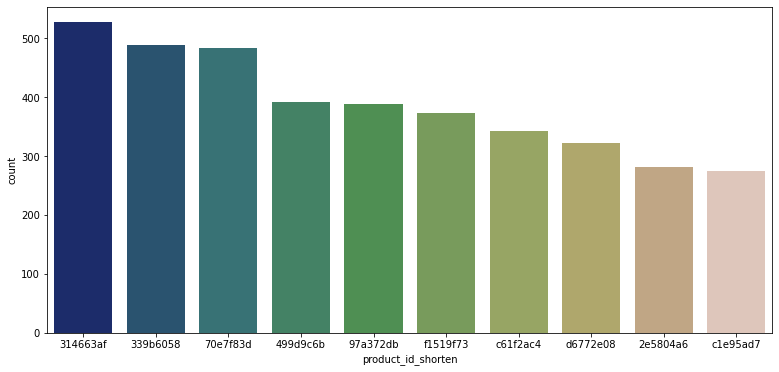

In [17]:
plt.figure(figsize=(13,6))
sns.countplot(x='product_id_shorten', data=orders, palette='gist_earth',
             order=orders['product_id_shorten'] \
.value_counts()[:10]\
.sort_values(ascending=False).index
)
# 10 самых продаваемых товаров за все время

In [18]:
orders['seller_id_shorten']=orders['seller_id'].str[-5:]
# Сократим имена продавцов для красивого вывода на графике

In [19]:
plt.figure(figsize=(13,6))
sns.countplot(x='seller_id_shorten', data=orders, palette='gist_earth',
             order=orders['seller_id_shorten'] \
.value_counts()[:10]\
.sort_values(ascending=False).index
)
# 10 самых доходных продавцов за все время

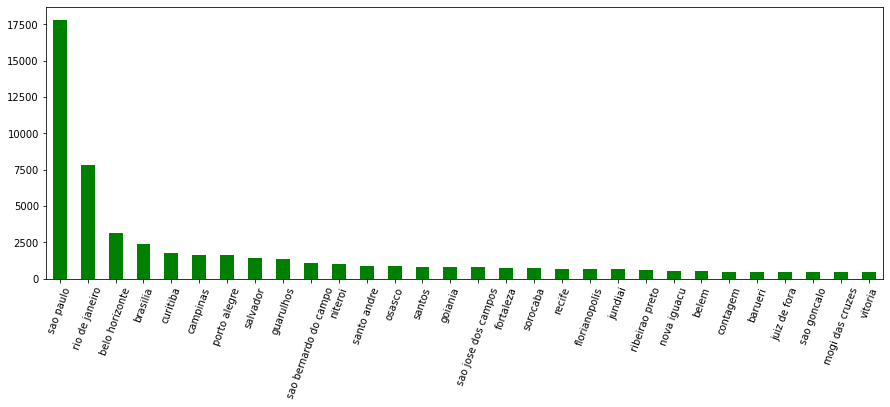

In [20]:
orders['customer_city'].value_counts() \
.sort_values(ascending=False) \
.head(30) \
.plot(kind='bar', figsize=(15, 5), color = 'g',rot=70)
# Распределение клиентов по городам

##### Приступим к заданиям
##### Задание 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [68]:
orders_items.query('order_status == "delivered"')\
    .groupby('customer_unique_id') \
    .agg(orders = ('order_id', 'nunique')) \
    .query('orders == 1') \
    .shape[0]


90557

С помощью классических методов вычислим количество уникальных покупателей, которые заказали, оплатили и получили свой заказ, при этом количество таких заказов равно 1 <br>
Таких уникальных пользователей **90557**

##### Задание 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [70]:
orders1 = orders_items.copy()

In [71]:
orders1['YearMonth'] = orders1.order_purchase_timestamp.dt.strftime('%Y-%m')

In [72]:
orders1 = orders1.query('order_status != "delivered"')
# Отберем все статусы заказов, отличные от "delivered" - доставленных

In [73]:
sns.countplot(orders1.order_status, palette="pastel")
# Бегло взглянем на распределение таких заказов

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Уже очевидно, что многие товары теряются на этапе доставки

In [74]:
orders1 = orders1.query('order_status == ["canceled", "unavailable", "processing", "shipped"]')\
.groupby(['order_status', pd.Grouper(key='YearMonth')])\
.agg({'order_id' : 'count'})
# Отберем только те статусы заказов, которые нам интересно исследовать для определения слабых мест, 
# назначаем индексом месяц даты заказа, считаем количество значений

In [75]:
orders1 = orders1.pivot_table(index='YearMonth', columns='order_status', values='order_id').fillna(0)
# Создаем сводную таблицу, определяем средние значения по группам, заполняем пропущенные значения нулями

In [76]:
orders1.style \
.background_gradient(cmap='YlOrRd')
# Выделим высокие значения в сводной таблице

Обнаружим, что большое количество заказов отправляются,но не получают статуса **'delivered'**. Проблема может быть как в работе службы доставки\почты, так и в ненадлежащем заполнении данных изменения статуса заказа. Целесообразно составить выборку заказов со статусом **'shipped'** и актуализировать их состояние - разыскать в службе доставки, позвонить клиентам, и устранить проблему, по которой эти отправления не доставляются.

В 2018г отменяемых заказов (**'cancelled'**) стало больше - важно разобраться в этих всплесках.
Также заметим, что до февраля 2018г была проблема с заказами, получавшими статусы **'processing'** и **'unavailable'**, которая сейчас устранена или возникает редко

In [81]:
orders1.mean().round(2)
# Обнаружим искомые средние значения

order_status
canceled       23.57
processing     15.52
shipped        51.52
unavailable     0.30
dtype: float64

In [77]:
round((len(orders_items.query('order_status != "delivered"')) / len(orders_items.order_status)) * 100, 2)
# Процент заказов с сомнительным статусом от общего числа заказов

2.18

##### Задание 3. По каждому товару определить, в какой день недели товар чаще всего покупается

In [7]:
orders2 = orders_items.copy()

In [8]:
orders2.order_purchase_timestamp = orders2.order_purchase_timestamp.dt.day_name()
# Определим дату формирования заказа как названия дней недели

In [9]:
orders2 = orders2.groupby(['product_id', 'order_purchase_timestamp'], as_index=False)\
.agg({'order_id' : 'count'})
# Группируем по колонкам с индивидуальным номером товара и дням недели, считаем количество заказов

In [10]:
agg_func_stats = {'order_purchase_timestamp': [pd.Series.mode]}
# Предполагаем, что в некоторые дни недели максимальных значений продажи товара может быть несколько,
# поэтому рассчитываем значение моды по дням недели

In [11]:
orders2.groupby('product_id').agg(agg_func_stats)
# Группируем по товарам и выводим дни недели; если мод несколько - выводим каждую

order_purchase_timestamp
                                                                 mode
product_id                                                           
00066f42aeeb9f3007548bb9d3f33c38                               Sunday
00088930e925c41fd95ebfe695fd2655                              Tuesday
0009406fd7479715e4bef61dd91f2462                             Thursday
000b8f95fcb9e0096488278317764d19                  [Friday, Wednesday]
000d9be29b5207b54e86aa1b1ac54872                              Tuesday
...                                                               ...
fff6177642830a9a94a0f2cba5e476d1                   [Saturday, Sunday]
fff81cc3158d2725c0655ab9ba0f712c                               Monday
fff9553ac224cec9d15d49f5a263411f                               Friday
fffdb2d0ec8d6a61f0a0a0db3f25b441  [Friday, Sunday, Thursday, Tuesday]
fffe9eeff12fcbd74a2f2b007dde0c58                            Wednesday

[32951 rows x 1 columns]

Изобразим распределение покупок по дням недели на барплоте (для наглядности)

In [12]:
graph1 = orders_items.copy()

In [13]:
graph1 = graph1['order_purchase_timestamp'].dt.day_name().value_counts().rename('Count').to_frame()
# Отберем данные для барплота, определим дату формирования заказа как названия дней недели, посчитаем, 
# переименуем колонку

In [14]:
sns.barplot(graph1.index, graph1.Count)
plt.xticks(rotation='20')
# Выведем барплот, развернем  подписи по оси Х для читаемости

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

##### Задание 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

In [142]:
orders4 = orders_items.copy()

In [143]:
orders4

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                  ...                               ...   
112645  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
112646  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
112647  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
112648  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
112649  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp   order_approved_at  \
0         delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1         delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2         delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3         delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4         delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...             ...                      ...                 ...   
112645    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
112646    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
112647    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
112648    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
112649    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

       order_estimated_delivery_date                customer_unique_id  \
0                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                         2018-08-13  af07308b275d755c9edb36a90c618231   
2                         2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                         2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                         2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   
...                              ...                               ...   
112645                    2018-03-02  da62f9e57a76d978d02ab5362c509660   
112646                    2017-09-27  737520a9aad80b3fbbdad19b66b37b30   
112647                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
112648                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
112649                    2018-04-03  60350aa974b26ff12caad89e55993bd6   

        customer_zip_code_prefix            customer_city customer_state  \
0                           3149                sao paulo             SP   
1                          47813                barreiras             BA   
2                          75265               vianopolis             GO   
3                          59296  sao goncalo do amarante             RN   
4                           9195              santo andre             SP   
...                          ...                      ...            ...   
112645                     11722             praia grande             SP   
112646                     45920              nova vicosa             BA   
112647                     28685                  japuiba             RJ   
112648                     28685                  japuiba             RJ   
112649                     83750                     lapa             PR   

        order_item_id                        product_id  \
0                   1  87285b34884572647811a353c7ac498a   
1                   1  595fac2a385ac33a80bd5114aec74eb8   
2                   1  aa4383b373c6aca5d8797843e5594415   
3                   1  d0b61bfb1de832b15ba9d266ca96e5b0   
4                   1  65266b2da20d04dbe00c5c2d3bb7859e   
...               ...                               ...   
112645              1  f1d4ce8c6dd66c47bbaa8c6781c2a923   
1126

In [144]:
orders4['Period_week'] = orders4.order_purchase_timestamp.dt.strftime('%Y-%m-%w')
orders4['Period_month'] = orders4.order_purchase_timestamp.dt.strftime('%Y-%m')
# Отберем недели и месяцы

In [145]:
orders4['customer_id_shorten'] = orders4['customer_unique_id'].str[-5:]
# Сократим имена покупателей для красивого вывода на графике

In [146]:
orders_bar = orders4['customer_id_shorten'].value_counts()
orders_bar = orders_bar.reset_index()
# Посмотрим на распределение числа заказов по пользователям. отберем данные, сбросим индекс

In [147]:
plt.figure(figsize=(12,7))
sns.barplot(orders_bar.customer_id_shorten, orders_bar.index, palette='pastel')
# Построим барплот

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Хорошо видно, что большинство клиентов делают заказ один раз, и совсем малое количество клиентов делает заказ более трех раз. Уточним, сколько пользователей делает заказ более 1 раза

In [148]:
orders4.value_counts('customer_id_shorten')\
.loc[lambda x : x > 1]

customer_id_shorten
884a1    24
ebd19    21
a6df8    20
4d4fb    20
bbffb    18
         ..
0aec9     2
759f4     2
73492     2
f02d4     2
e2278     2
Length: 14885, dtype: int64

Всего у нас **14885** таких пользователей
Очевидно, что средние значения окажутся невысокими

In [149]:
orders4 = orders4.groupby(['Period_month', 'Period_week'], as_index = False) \
.agg({'customer_id_shorten': pd.Series.nunique,
                        'order_id': 'nunique'})
orders4.rename(columns={'customer_id_shorten': 'TotalUsers',
                              'order_id' : 'TotalOrders'}, inplace=True)
# Сгруппируем по неделям и месяцам, посчитаем количество уникальных пользователей и заказов, переименуем колонки

In [150]:
orders4['mean_order_per_customer'] = round(orders4['TotalOrders'] / orders4['TotalUsers'], 2)
# Определим колонку со средним количеством заказов на пользователя

In [151]:
orders4

Period_month Period_week  TotalUsers  TotalOrders  mean_order_per_customer
0        2016-09   2016-09-0           1            1                     1.00
1        2016-09   2016-09-1           1            1                     1.00
2        2016-09   2016-09-4           1            1                     1.00
3        2016-10   2016-10-0          27           27                     1.00
4        2016-10   2016-10-1          44           45                     1.02
..           ...         ...         ...          ...                      ...
147      2018-08   2018-08-3        1101         1107                     1.01
148      2018-08   2018-08-4        1041         1042                     1.00
149      2018-08   2018-08-5         915          920                     1.01
150      2018-08   2018-08-6         696          696                     1.00
151      2018-09   2018-09-1           1            1                     1.00

[152 rows x 5 columns]

В результирующей таблице можем видеть среднее количество заказов на каждого покупателям (**'mean_order_per_customer'**) по неделям (**'Period_week'**)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Mean orders per customer')

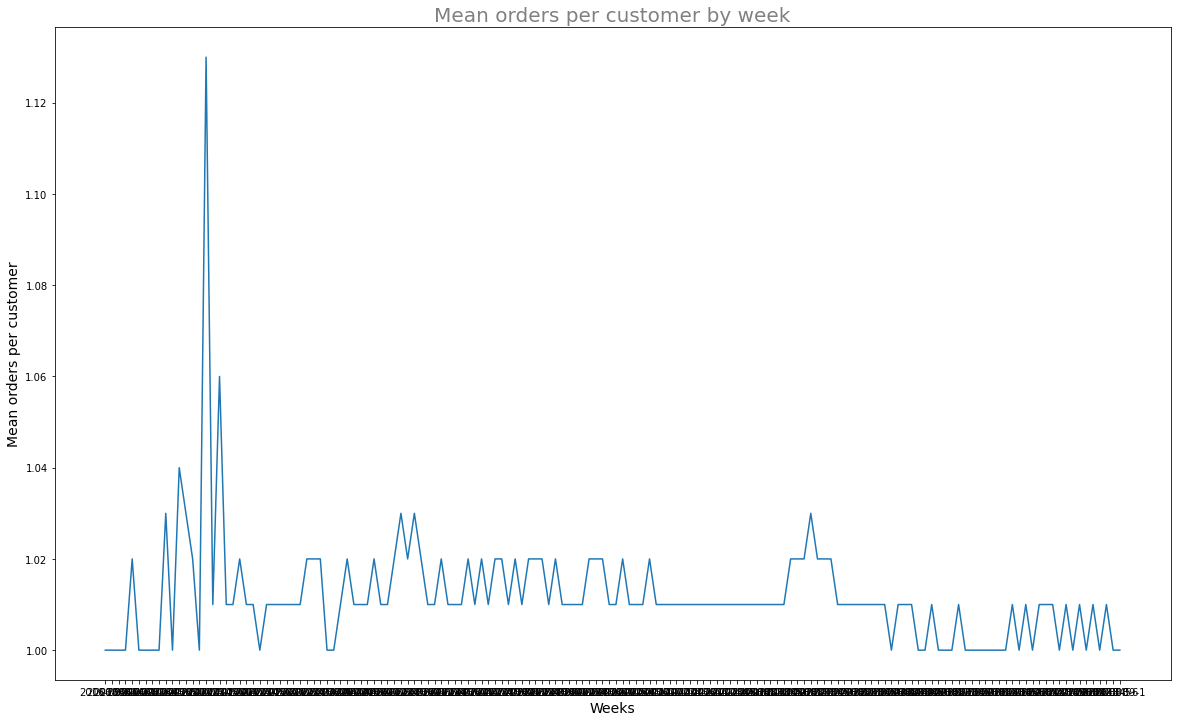

In [152]:
plt.figure(figsize=(20,12))
sns.lineplot(orders4.Period_week, orders4.mean_order_per_customer, palette='Greens_d')
plt.title('Mean orders per customer by week', size=20, color='grey')
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("Mean orders per customer", fontsize=14)
# Распределение среднего количества заказов на каждого покупателям по неделям

In [153]:
plt.figure(figsize=(28,10))
sns.barplot(orders4.Period_month, orders4.mean_order_per_customer, palette='YlOrRd')
plt.title('Mean orders per customer by month', size=24, color='grey')
plt.xlabel("Months", fontsize=18)
plt.ylabel("Mean orders per customer", fontsize=18)
plt.xticks(rotation='20')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

##### Задание 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц

In [161]:
orders3 = orders_items.copy()

In [162]:
orders3['CohortPeriod'] = orders3.order_purchase_timestamp.dt.strftime('%Y-%m')
# Определяем когорты пользователей: клиенты, совершившие покупку по месяцам

In [163]:
orders3.set_index('customer_unique_id', inplace=True)
orders3['JoinMonth'] = orders3.groupby(level=0)['order_purchase_timestamp'].min()\
.apply(lambda x: x.strftime('%Y-%m'))
orders3.reset_index(inplace=True)

# Назначаем индексацию по id клиента, добавляем столбец JoinMonth, в который переносим месяц и год 
# первой покупки каждого клиента, снимаем индексацию 

In [164]:
cohort_orders = orders3.groupby(['JoinMonth', 'CohortPeriod']) \
.agg({'customer_unique_id': pd.Series.nunique,
                        'price': 'sum',
                        'order_id': 'nunique'})
cohort_orders.rename(columns={'customer_unique_id': 'TotalUsers',
                              'price': 'Revenue',
                              'order_id' : 'TotalOrders'}, inplace=True)
# Группируем по когортам и периодам, считаем количество уникальных клиентов, сумму покупок и их количество

In [165]:
def cohort_period(df):
     df['CohortPeriods'] = np.arange(len(df)) + 1
     return df
cohort_orders = cohort_orders.groupby(level=0).apply(cohort_period)
# Оценим, как изменялись когорты после их первой покупки. Для этого назначим CohortPeriod = 1 - первый месяц когорты,
# CohortPeriod = 2 - второй месяц и так далее

In [166]:
cohort_orders.reset_index('JoinMonth', inplace=True)
# Сбросим индекс 

In [167]:
def get_cohort_matrix(df, period='M', percentage=False):
    
    df = df.pivot_table(index = 'JoinMonth',
                                        columns = 'CohortPeriods',
                                        values = 'TotalUsers')
    
    if percentage:
        df = df.divide(df.iloc[:,0], axis=0)*100
    
    return df

# Напишем функцию для создания сводной таблицы когорт

In [168]:
cohort_pivot = get_cohort_matrix(cohort_orders, 'M', percentage=True)
# Создадим помесячные когорты с процентной разбивкой Retention

In [169]:
cohort_pivot
# Результирующая сводная таблица с процентным Retention 

CohortPeriods     1           2         3         4         5         6   \
JoinMonth                                                                  
2016-09        100.0         NaN       NaN       NaN       NaN       NaN   
2016-10        100.0    0.327869  0.327869  0.327869  0.327869  0.327869   
2016-12        100.0  100.000000       NaN       NaN       NaN       NaN   
2017-01        100.0    0.397878  0.265252  0.132626  0.397878  0.132626   
2017-02        100.0    0.234604  0.293255  0.117302  0.410557  0.117302   
2017-03        100.0    0.500963  0.346821  0.385356  0.346821  0.154143   
2017-04        100.0    0.598546  0.213767  0.171013  0.342027  0.256520   
2017-05        100.0    0.477528  0.477528  0.393258  0.308989  0.337079   
2017-06        100.0    0.481696  0.353243  0.385356  0.256904  0.385356   
2017-07        100.0    0.520427  0.364299  0.234192  0.286235  0.208171   
2017-08        100.0    0.674861  0.337431  0.265124  0.361533  0.530248   
2017-09        100.0    0.684597  0.537897  0.293399  0.440098  0.220049   
2017-10        100.0    0.702629  0.249320  0.090662  0.226655  0.203989   
2017-11        100.0    0.554247  0.387973  0.180130  0.193986  0.180130   
2017-12        100.0    0.220507  0.275634  0.349136  0.257258  0.202132   
2018-01        100.0    0.343692  0.372333  0.286410  0.286410  0.157525   
2018-02        100.0    0.389287  0.389287  0.295858  0.264715  0.218001   
2018-03        100.0    0.446236  0.316683  0.287894  0.129552  0.115158   
2018-04        100.0    0.581309  0.313012  0.238486  0.134148       NaN   
2018-05        100.0    0.529982  0.272562  0.211993       NaN       NaN   
2018-06        100.0    0.421301  0.269633       NaN       NaN       NaN   
2018-07        100.0    0.512058       NaN       NaN       NaN       NaN   
2018-08        100.0    0.016031       NaN       NaN       NaN       NaN   

CohortPeriods        7         8         9         10        11        12  \
JoinMonth                                                                   
2016-09             NaN       NaN       NaN       NaN       NaN       NaN   
2016-10        0.327869  0.655738  0.655738       NaN       NaN       NaN   
2016-12             NaN       NaN       NaN       NaN       NaN       NaN   
2017-01        0.397878  0.132626  0.132626  0.397878  0.132626  0.663130   
2017-02        0.234604  0.175953  0.117302  0.175953  0.117302  0.293255   
2017-03        0.154143  0.308285  0.346821  0.077071  0.385356  0.115607   
2017-04        0.342027  0.299273  0.299273  0.171013  0.256520  0.085507   
2017-05        0.421348  0.140449  0.252809  0.280899  0.252809  0.337079   
2017-06        0.385356  0.224791  0.128452  0.224791  0.321130  0.353243   
2017-07        0.312256  0.104085  0.182149  0.260213  0.208171  0.286235   
2017-08        0.289226  0.265124  0.144613  0.144613  0.241022  0.192818   
2017-09        0.220049  0.244499  0.293399  0.171149  0.268949  0.073350   
2017-10        0.226655  0.362647  0.271985  0.203989  0.203989       NaN   
2017-11        0.110849  0.193986  0.138562  0.055425       NaN       NaN   
2017-12        0.165380  0.018376  0.220507       NaN       NaN       NaN   
2018-01        0.171846  0.229128       NaN       NaN       NaN       NaN   
2018-02        0.202429       NaN       NaN       NaN       NaN       NaN   
2018-03             NaN       NaN       NaN       NaN       NaN       NaN   
2018-04             NaN       NaN       NaN       NaN       NaN       NaN   
2018-05             NaN       NaN       NaN       NaN       NaN       NaN   
2018-06             NaN       NaN       NaN       NaN       NaN       NaN   
2018-07             NaN       NaN       NaN       NaN       NaN       NaN   
2018-08             NaN       NaN       NaN       NaN       NaN       NaN   

CohortPeriods        13        14        15        16        17        18  
JoinMonth                                                                  
2016-09             N

In [170]:
f, ax = plt.subplots(figsize=(20, 9))
cmap = sns.color_palette("Blues")

sns.heatmap(cohort_pivot,
            annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap, 
                    square=False)

ax.axes.set_title("Cohort analysis",fontsize=20)
ax.set_xlabel("Cohorts",fontsize=15)
ax.set_ylabel("Period by month",fontsize=15)
plt.show()

# Изобразим heatmap

Наглядно очевидно, что самый высокий Retention за третий месяц в когорте сентября 2017, однако уже в четвертом месяце он резко снижается.
В наших силах дополнительно оценить изменение количества заказов по месяцам

In [59]:
orders3['order_purchase_year_month'] = orders3['order_purchase_timestamp'].dt.strftime('%Y%m')
# Назначим колонку с датой заказа

In [60]:
plt.figure(figsize=(15,6))
sns.lineplot(data = orders3['order_purchase_year_month'].value_counts().sort_index(),
             color='blue', linewidth=2)
plt.title('Evolution of Total Orders', size=14, color='dimgrey')
plt.xticks(rotation=40)
plt.show()

Совершенно очевидно, что общая тенденция - на повышение (падение в сентябре 2019 объясняется малым количеством данных)
Внимания так же заслуживает период с марта по май 2018г, когда число заказов падало, а доходность **Revenue** росла. 
Кроме того, в дальнейшем число заказов в месяц продолжило снижаться, но средняя стоимость заказа (**'mean_payment_per_order'**) преимущественно росла: вероятно, есть фактор, на это повлиявший - улучшение качества товаров или рекламной кампании

##### Задание 6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию

In [61]:
ordered_delivered = orders_items.query('order_status == "delivered"')
# Выделим полностью завершенные заказы

In [62]:
ordered_delivered['today'] = ordered_delivered['order_purchase_timestamp'].max()
# Установим последний день датасета как сегодняшний - для удобного подсчета периодов Recency 

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
ordered_delivered['time_delta'] = ordered_delivered['today'] - ordered_delivered['order_purchase_timestamp']
# Определим дельту между "сегодняшним" днем и днем заказа

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
ordered_delivered = ordered_delivered.groupby(['customer_unique_id', 'order_id'], as_index=False) \
.agg({'order_purchase_timestamp': 'first',
        'today': 'first',
        'time_delta': 'first',
        'price' : 'sum'})
# Группируем нужные нам данные, рассчитываем дельту для каждого заказа

In [65]:
rfm = ordered_delivered.groupby('customer_unique_id', as_index=False)\
    .agg({'time_delta': ['min', 'max', 'count'], 'price': 'sum'})
# Рассчитываем данные для времени и цены

In [66]:
rfm.columns = [' '.join(col).strip() for col in rfm.columns.values]
# Для переименования столбцов уберем пробелы

In [67]:
rfm.rename(columns={
    'time_delta max': 'days_since_first_order',
    'time_delta min': 'recency',
    'time_delta count': 'frequency',
    'price sum': 'monetary'
    }, inplace=True)
# Переименуем колонки для удобства 

In [68]:
rfm

customer_unique_id           recency  \
0      0000366f3b9a7992bf8c76cfdf3221e2 111 days 04:04:10   
1      0000b849f77a49e4a4ce2b2a4ca5be3f 114 days 03:49:10   
2      0000f46a3911fa3c0805444483337064 536 days 17:55:34   
3      0000f6ccb0745a6a4b88665a16c9f078 320 days 18:30:56   
4      0004aac84e0df4da2b147fca70cf8255 287 days 19:14:55   
...                                 ...               ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684 446 days 18:00:01   
93354  fffea47cd6d3cc0a88bd621562a9d061 261 days 18:52:41   
93355  ffff371b4d645b6ecea244b27531430a 567 days 23:11:21   
93356  ffff5962728ec6157033ef9805bacc48 118 days 23:42:56   
93357  ffffd2657e2aad2907e67c3e9daecbeb 483 days 18:41:52   

      days_since_first_order  frequency  monetary  
0          111 days 04:04:10          1    129.90  
1          114 days 03:49:10          1     18.90  
2          536 days 17:55:34          1     69.00  
3          320 days 18:30:56          1     25.99  
4          287 days 19:14:55          1    180.00  
...                      ...        ...       ...  
93353      446 days 18:00:01          1   1570.00  
93354      261 days 18:52:41          1     64.89  
93355      567 days 23:11:21          1     89.90  
93356      118 days 23:42:56          1    115.00  
93357      483 days 18:41:52          1     56.99  

[93358 rows x 5 columns]

Обращаем внимание, что значения в колонкам **recency** и **days_since_first_order** в выводной части таблицы совпадают - это говорит о том, что многие клиенты совершили единственный заказ

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


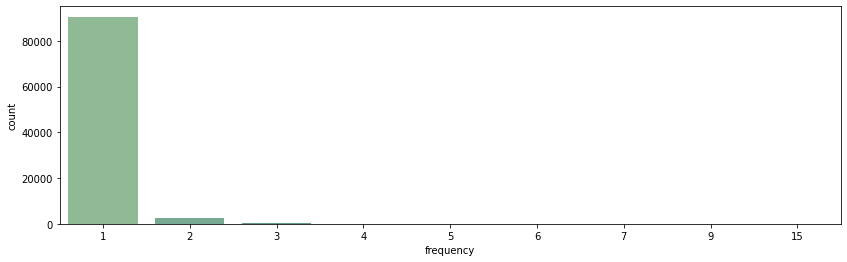

In [69]:
plt.figure(figsize=(14,4))
sns.countplot(rfm.frequency, palette='crest')

Как и ожидалось, клиенты в нашем датасете преимущественно делают заказ только единожды за всё время,
и лишь малая часть - два и более раз

In [70]:
def frequency (x):
    if x >= 4:
        return 4
    if x >= 3:
        return 3
    if x >= 2:
        return 2
    else:
        return 1

# Определим границы Frequency. Так как другие показатели мы будем делить по квартилям, этот показатель
# тоже разделим на 4 категории, хотя очевидно, что большинство будет принадлежать наименьшей

In [71]:
rfm['F'] = rfm['frequency'].apply(frequency)
# Назначим колонку с сегментацией Frequency 

In [72]:
rfm['R'] = pd.qcut(rfm['recency'], q=4,  labels=range(4, 0, -1))
# Назначим колонку с сегментацией Recency по квартилям при помощи функции qcut(), 
# лейблы назначим по убыванию от 4 до 1

In [73]:
rfm['M'] = pd.qcut(rfm['monetary'], q=4, labels=range(1, 5))
# Назначим колонку с сегментацией Monetary по квартилям при помощи функции qcut(), 
# лейблы назначим по возрастанию от 1 до 4

In [74]:
rfm['RFM'] = rfm['R'].astype(str)\
    + rfm['F'].astype(str)\
    + rfm['M'].astype(str)

# Создадим индивидуальные имена всем сочетаниям, и назначим это имя каждому заказу

In [75]:
rfm.RFM.unique()

array(['413', '311', '112', '211', '214', '313', '314', '113', '111',
       '212', '312', '114', '412', '411', '414', '213', '224', '422',
       '123', '324', '424', '124', '321', '223', '423', '222', '434',
       '421', '122', '433', '322', '121', '323', '133', '334', '444',
       '234', '333', '344', '142', '233', '432', '332', '221', '134',
       '131', '232', '141', '144', '244', '132'], dtype=object)

Вышел 51 тип клиентов, а если бы присутствовали все сочетания - было бы 4^3 = 64 типа. Это связано с тем, что отсутствуют некоторые сочетания

In [76]:
rfm['F'] = rfm['F'].astype(str)
rfm['M'] = rfm['M'].astype(str)
rfm['R'] = rfm['R'].astype(str)
rfm.dtypes
# Сменим тип данных в колонках для преобразования при помощи регулярных выржаений

customer_unique_id                 object
recency                   timedelta64[ns]
days_since_first_order    timedelta64[ns]
frequency                           int64
monetary                          float64
F                                  object
R                                  object
M                                  object
RFM                                object
dtype: object

In [77]:
segt_map = {
    r'[1-2][1-2][1-2]': 'hibernating',
    r'[1-2][1-4][3-4]': 'big lost',
    r'[1-2][3-4][1-2]': 'at risk',
    r'[3-4][3-4][1-4]': 'loyal customers',
    r'41[1-4]': 'new customers',
    r'[3-4][1-2][1-4]': 'potential loyalists',
    r'[3-4][3-4][3-4]': 'best customers'
}

rfm['segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm['segment'] = rfm['segment'].replace(segt_map, regex=True)


# Назначим имена каждому типу клиента в зависимости от уровней Recency, Frequency, Monetary

**hibernating** - совершили одну-две покупку на небольшую сумму давно и не вернулись \
**big lost** - совершили большую покупку либо много покупок давно и не вернулись \
**at risk** - покупали несколько раз довольно давно на небольшие суммы и не вернулись \
**new customers** - были недавно, и пока не вернулись \
**loyal customers** - тратят регулярно и были недавно, вне зависимости от потраченной суммы \
**potential loyalists** - были недавно, время от времени возвращаются, вне зависимости от потраченной суммы \
**best customers** - последнюю покупку совершали недавно, часто возвращаются, много тратят


In [78]:
rfm['recency'] = rfm['recency'].astype(str)
rfm['recency'] = rfm['recency'].str.replace(r'\s+days.*', '', regex=True)
rfm['recency'] = rfm['recency'].astype(int)
# Для представления таблицы для презентации, преобразуем данные в столбце Recency, имеющие тип timedelta, 
# в строку, чтобы избавится от ненужных частей данных о времени, оставив только количество дней, 
# и преобразуем в числовой тип данных

In [79]:
strategy_map = {
    r'big lost': 'Make them feel valued and remind about the quality of your product',
    r'hibernating': 'Offer them great discounts',
    r'at risk': 'Offer them limited sales promotions',
    r'need attention': 'Offer them limited sales promotions',
    r'new customers': 'Regurarly recommend them new products',
    r'best customers': 'Personalize communaction, offer private discounts',
    r'loyal customers': 'Offer them advanced loyality program',
    r'potential loyalists': 'Offer them loyality program and special prices'
}
rfm['strategy'] = rfm['segment'].map(str)
rfm['strategy'] = rfm['strategy'].replace(strategy_map, regex=True)
# Добавим колонку со стратегией работы с каждой группой клиентов

In [80]:
rfm.groupby('segment').agg(
    Number = ('customer_unique_id', 'count'),
    Recency = ('recency', 'mean'),
    Frequency = ('frequency', 'mean'),
    Monetary = ('monetary', 'mean'),
    Strategy = ('strategy', 'unique')
).round(1)
# Посчитаем количество клиентов в каждом сегменте, и средние по сегментам показатели Recency, Frequency, Monetary,
# округлим до одного знака после запятой

Number  Recency  Frequency  Monetary  \
segment                                                     
at risk                   9    513.3        3.6      48.6   
big lost              23079    363.0        1.0     236.5   
hibernating           23591    363.2        1.0      47.4   
loyal customers         142    104.0        3.5     453.8   
new customers         22558     56.4        1.0     140.3   
potential loyalists   23979    162.0        1.1     142.5   

                                                              Strategy  
segment                                                                 
at risk                          [Offer them limited sales promotions]  
big lost             [Make them feel valued and remind about the qu...  
hibernating                               [Offer them great discounts]  
loyal customers                 [Offer them advanced loyality program]  
new customers                  [Regurarly recommend them new products]  
potential loyalists   [Offer them loyality program and special prices]

Как мы видим, несколько из выделенных нами сегментов просто не существуют из-за того, что в датасете нет клиентов, которые вернулись за повторными покупками. \
У нас два слабых места: отсутствует сегмент **"best customers"** -  клиенты, которые приносят много денег и покупают часто, а это наиболее доходные клиенты, и отсутствует сегмент **"loyal customers"** - те, кто тратят не так много, зато регулярно. Маркетингу стоит обратить внимание на работу с этими клиентами, переводя клиентов
из других сегментов в эти, более доходные. \
Особенно печально видеть большое количество клиентов в сегменте **"big lost"** - клиентов, которые потратили много,
но не вернулись за второй покупкой. С ними должна быть проведена тщательная работа: потенциально они могут стать
"best customers". \
C другой стороны, у нас огромное количество клиентов в категории **"new customers"** - тех, кто сделал покупку недавно, и мы, безусловно, должны сосредоточить на них значительное внимание, чтобы они совершили покупки вновь

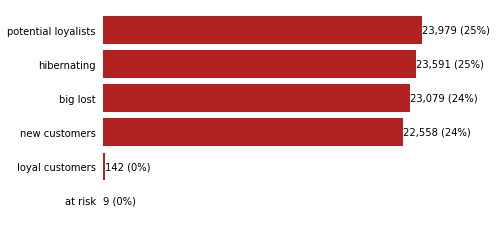

In [81]:
# И немного визуализации

segments_counts = rfm['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='firebrick')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()